In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


## Import Necessary Libraries

In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
import cv2
from tqdm import tqdm
import os
from os import listdir
import re
from PIL import Image
import gc

In [3]:
SIZE = 256

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs
! unzip cuhk-face-sketch-database-cufs.zip

Processing Sketches: 100%|██████████| 188/188 [00:00<00:00, 596.04it/s]


Processed 188 images and 188 sketches.
Training set: 150 images and 150 sketches.
Testing set: 38 images and 38 sketches.


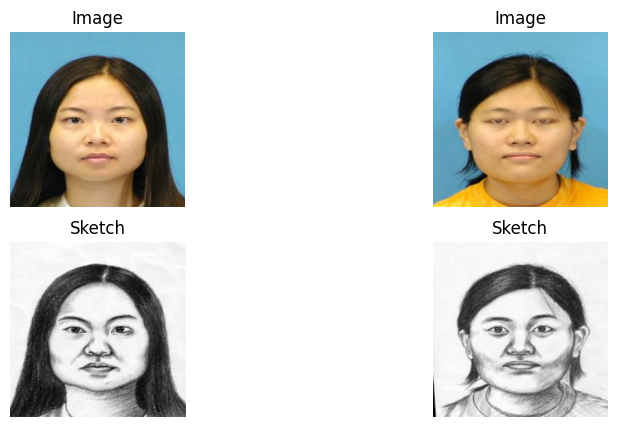

In [5]:
# Function to normalize images
def normalize(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    arr_range = arr_max - arr_min
    scaled = np.array((arr - arr_min) / float(arr_range), dtype='f')
    arr_new = -1 + (scaled * 2)
    return arr_new

# Function to sort files alphanumerically
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Function to process and normalize images and sketches
def process_images(image_path, sketch_path, size=SIZE):
    img_array = []
    sketch_array = []

    image_files = sorted_alphanumeric(os.listdir(image_path))
    sketch_files = sorted_alphanumeric(os.listdir(sketch_path))

    for i in tqdm(image_files, desc="Processing Images"):
        image = cv2.imread(os.path.join(image_path, i), 1)
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Resize images
        image = cv2.resize(image, (size, size))
        # Normalize image
        image = normalize(image)
        # Append normal image
        img_array.append(img_to_array(image))

    for i in tqdm(sketch_files, desc="Processing Sketches"):
        image = cv2.imread(os.path.join(sketch_path, i), 1)
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Resize images
        image = cv2.resize(image, (size, size))
        # Normalize sketch
        image = normalize(image)
        # Append normal sketch
        sketch_array.append(img_to_array(image))

    return np.array(img_array), np.array(sketch_array)

# Function to display 2 image-sketch pairs
def show_image_sketch_pairs(images, sketches, num_pairs=2):
    plt.figure(figsize=(10, 5))
    for i in range(num_pairs):
        plt.subplot(2, num_pairs, i + 1)
        plt.imshow((images[i] + 1) * 127.5 / 255.0)  # Denormalize to [0, 1]
        plt.title("Image")
        plt.axis("off")

        plt.subplot(2, num_pairs, i + 1 + num_pairs)
        plt.imshow((sketches[i] + 1) * 127.5 / 255.0)  # Denormalize to [0, 1]
        plt.title("Sketch")
        plt.axis("off")
    plt.show()

# Function to split dataset into training and testing sets
def split_dataset(images, sketches, train_size=150):
    train_images = images[:train_size]
    test_images = images[train_size:]
    train_sketches = sketches[:train_size]
    test_sketches = sketches[train_size:]
    return train_images, test_images, train_sketches, test_sketches

# Paths to folders containing images and sketches
image_path = '/content/photos'
sketch_path = '/content/sketches'

# Process images and sketches
images, sketches = process_images(image_path, sketch_path)

print(f'Processed {len(images)} images and {len(sketches)} sketches.')

# Split the dataset
train_images, test_images, train_sketches, test_sketches = split_dataset(images, sketches)

# Reshape the arrays
train_images = np.reshape(train_images, (len(train_images), SIZE, SIZE, 3))
train_sketches = np.reshape(train_sketches, (len(train_sketches), SIZE, SIZE, 3))
test_images = np.reshape(test_images, (len(test_images), SIZE, SIZE, 3))
test_sketches = np.reshape(test_sketches, (len(test_sketches), SIZE, SIZE, 3))

print(f'Training set: {len(train_images)} images and {len(train_sketches)} sketches.')
print(f'Testing set: {len(test_images)} images and {len(test_sketches)} sketches.')

# Show 2 image-sketch pairs from the training set
show_image_sketch_pairs(train_images, train_sketches)

Train Dataset Samples:


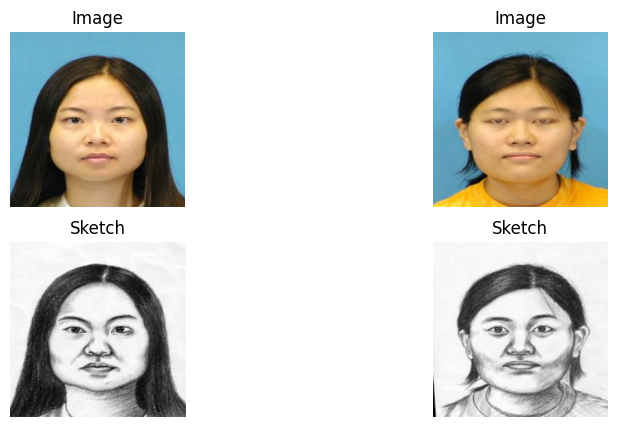

Test Dataset Samples:


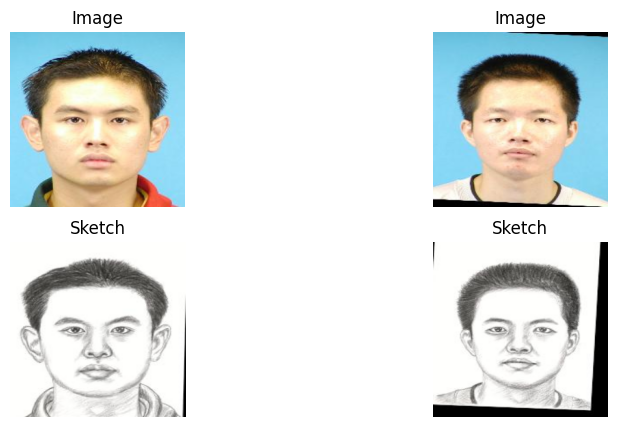

In [6]:
# Function to denormalize images
def denormalize(image):
    # Denormalize from [-1, 1] to [0, 1]
    return (image + 1.0) * 0.5

# Function to display images from arrays
def show_images_from_arrays(images_array, sketches_array, num_images=2):
    plt.figure(figsize=(10, 5))

    # Ensure we don't exceed available images
    num_images = min(num_images, len(images_array))

    # Display the images and sketches
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(denormalize(images_array[i]))  # Denormalize to [0, 1]
        plt.title("Image")
        plt.axis("off")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(denormalize(sketches_array[i]), cmap="gray")  # Denormalize to [0, 1]
        plt.title("Sketch")
        plt.axis("off")

    plt.show()

# Display images from arrays
print("Train Dataset Samples:")
show_images_from_arrays(train_images, train_sketches)

print("Test Dataset Samples:")
show_images_from_arrays(test_images, test_sketches)

In [7]:
batch_size = 8
latent_dim = 128
def prepare_dataset(dataset, batch_size, shuffle_buffer_size=None):
    if shuffle_buffer_size:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def data_generator(images, sketches):
    for img, sketch in zip(images, sketches):
        yield img, sketch

def generator_fn(images, sketches):
    return data_generator(images, sketches)

train_dataset = tf.data.Dataset.from_generator(
    lambda: generator_fn(train_images, train_sketches),
    output_signature=(
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: generator_fn(test_images, test_sketches),
    output_signature=(
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32)
    )
)

# Prepare datasets
train_dataset = prepare_dataset(train_dataset, batch_size=batch_size, shuffle_buffer_size=len(train_images))
test_dataset = prepare_dataset(test_dataset, batch_size=batch_size)

Train Dataset Samples:


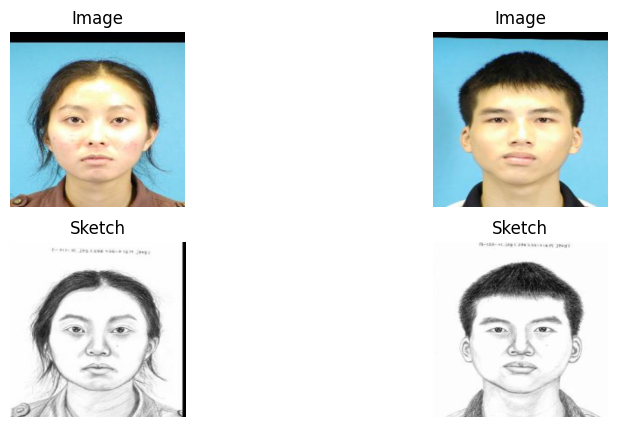

Test Dataset Samples:


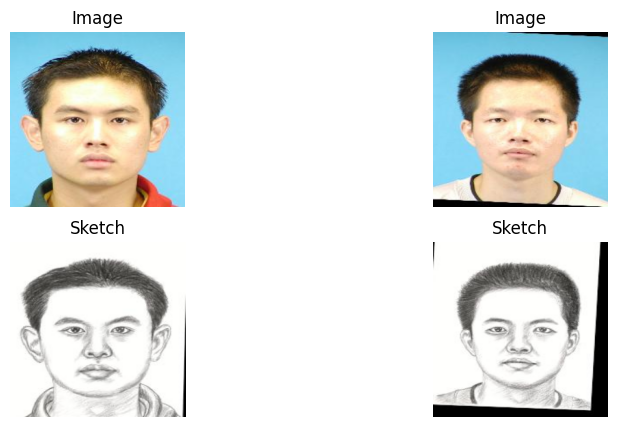

In [8]:
# Function to denormalize images
def denormalize(image):
    # Denormalize from [-1, 1] to [0, 1]
    return (image + 1.0) * 0.5

# Function to display images from the dataset
def show_images_from_dataset(dataset, num_images=2):
    plt.figure(figsize=(10, 5))

    # Collect a few images and sketches to display
    images_list = []
    sketches_list = []

    for images, sketches in dataset:
        images_list.extend(images.numpy())
        sketches_list.extend(sketches.numpy())

        if len(images_list) >= num_images:
            break

    # Ensure we don't exceed available images
    num_images = min(num_images, len(images_list))

    # Display the images and sketches
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(denormalize(images_list[i]))  # Denormalize to [0, 1]
        plt.title("Image")
        plt.axis("off")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(denormalize(sketches_list[i]), cmap="gray")  # Denormalize to [0, 1]
        plt.title("Sketch")
        plt.axis("off")

    plt.show()

# Display images from train and test datasets
print("Train Dataset Samples:")
show_images_from_dataset(train_dataset)

print("Test Dataset Samples:")
show_images_from_dataset(test_dataset)

In [9]:
def downsample(filters, size, apply_batch_normalization=True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(
        filters=filters,
        kernel_size=size,
        strides=2,
        padding='same',  # Use 'same' or 'valid' for string padding
        use_bias=False,
        kernel_initializer='he_normal'
    ))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

In [10]:
def upsample(filters, size, apply_dropout=True, apply_batch_normalization=True):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(
        filters=filters,
        kernel_size=size,
        strides=2,
        padding='same',  # Use 'same' or 'valid' for string padding
        use_bias=False,
        kernel_initializer='he_normal'
    ))
    if apply_dropout:
        upsample.add(keras.layers.Dropout(0.1))
    if apply_batch_normalization:
        upsample.add(keras.layers.BatchNormalization())
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [21]:
def build_encoder():
    encoder_input = keras.Input(shape=(256, 256, 3), name="img")

    # Downsample layers
    x = downsample(32, 4, apply_batch_normalization=False)(encoder_input)  # (128, 128, 32)
    x = downsample(64, 4, apply_batch_normalization=True)(x)  # (64, 64, 64)
    x = downsample(128, 4, apply_batch_normalization=False)(x)  # (32, 32, 128)
    x = downsample(256, 4)(x)  # (16, 16, 256)

    # Output layer
    encoder_output = keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu')(x)  # (16, 16, 512)

    return keras.Model(encoder_input, encoder_output, name="encoder")

encoder = build_encoder()

In [22]:
def build_generator():
    generator_input = keras.Input(shape=(16, 16, 512))
    x = upsample(256, 4, apply_batch_normalization=True)(generator_input)
    x = upsample(128, 4)(x)
    x = upsample(64, 4,)(x)
    x = upsample(32, 4,)(x)
    generator_output = keras.layers.Conv2D(
        filters=3,
        kernel_size=4,
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(x)
    return keras.Model(generator_input, generator_output, name="generator")

generator = build_generator()

In [23]:
def build_discriminator():
    discriminator_input = keras.Input(shape=(256, 256, 3))
    x = downsample(64, 4, apply_batch_normalization=False)(discriminator_input)
    x = downsample(128, 4, apply_batch_normalization=True)(x)
    x = downsample(256, 4, apply_batch_normalization=False)(x)
    x = downsample(512, 4)(x)
    discriminator_output = keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(x)
    return keras.Model(discriminator_input, discriminator_output, name="discriminator")

discriminator = build_discriminator()

In [14]:
# Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Function to normalize images
@tf.function
def normalize(arr):
    arr_min = tf.reduce_min(arr)
    arr_max = tf.reduce_max(arr)
    arr_range = arr_max - arr_min
    scaled = (arr - arr_min) / arr_range
    return -1 + (scaled * 2)

# Define optimizers with mixed precision
generator_optimizer = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
encoder_optimizer = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

# Define loss functions
binary_cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
mae = keras.losses.MeanAbsoluteError()

@tf.function
def train_step(real_images, real_sketches):
    batch_size = tf.shape(real_images)[0]

    # Sample from the prior distribution
    # Adjust the size to match the difference between the generator's expected input and the encoder's output
    prior_latent_size = 512 - (16 * 16 * 512)  # This should result in 0, meaning we don't need additional latent input
    prior_latent_sample = tf.random.normal(shape=(batch_size, prior_latent_size))

    with tf.GradientTape(persistent=True) as tape:
        # Encode real images
        latent_code = encoder(real_images, training=True)

        # Reshape latent code to match generator input shape
        latent_code_reshaped = tf.reshape(latent_code, [batch_size, 16, 16, 512])

        # If prior_latent_size is not 0, concatenate it with the reshaped latent code
        if prior_latent_size > 0:
            prior_latent_reshaped = tf.reshape(prior_latent_sample, [batch_size, 16, 16, -1])
            combined_latent = tf.concat([latent_code_reshaped, prior_latent_reshaped], axis=-1)
        else:
            combined_latent = latent_code_reshaped

        # Generate sketches using the combined latent code
        generated_sketches = generator(combined_latent, training=True)

        real_output = discriminator(real_sketches, training=True)
        fake_output = discriminator(generated_sketches, training=True)

        epsilon = 1e-10
        disc_loss = binary_cross_entropy(tf.ones_like(real_output), real_output + epsilon) + \
                    binary_cross_entropy(tf.zeros_like(fake_output), fake_output + epsilon)

        gen_loss = binary_cross_entropy(tf.ones_like(fake_output), fake_output + epsilon)
        reconstruction_loss = mae(real_sketches, generated_sketches)
        total_loss = gen_loss + reconstruction_loss

    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = tape.gradient(total_loss, generator.trainable_variables)
    gradients_of_encoder = tape.gradient(total_loss, encoder.trainable_variables)

    # Apply gradient clipping
    gradients_of_discriminator = [tf.clip_by_norm(g, 1.0) for g in gradients_of_discriminator]
    gradients_of_generator = [tf.clip_by_norm(g, 1.0) for g in gradients_of_generator]
    gradients_of_encoder = [tf.clip_by_norm(g, 1.0) for g in gradients_of_encoder]

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    encoder_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))

    return {"disc_loss": disc_loss, "gen_loss": gen_loss, "reconstruction_loss": reconstruction_loss}

# Training loop
epochs = 100

# Define model checkpoints
checkpoint_prefix = "/content/checkpoints/ckpt"
checkpoint_dir = "/content/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Create a checkpoint object
ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           encoder=encoder,
                           generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer,
                           encoder_optimizer=encoder_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=3)

# Restore the latest checkpoint if it exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    epoch_disc_loss = 0
    epoch_gen_loss = 0
    epoch_recon_loss = 0
    num_batches = 0

    for real_images_batch, real_sketches_batch in train_dataset:
        # Remove normalization step
        losses = train_step(real_images_batch, real_sketches_batch)
        epoch_disc_loss += losses['disc_loss']
        epoch_gen_loss += losses['gen_loss']
        epoch_recon_loss += losses['reconstruction_loss']
        num_batches += 1

    avg_disc_loss = epoch_disc_loss / num_batches
    avg_gen_loss = epoch_gen_loss / num_batches
    avg_recon_loss = epoch_recon_loss / num_batches

    print(f"Discriminator loss: {avg_disc_loss:.4f}, Generator loss: {avg_gen_loss:.4f}, Reconstruction loss: {avg_recon_loss:.4f}")

    # Clear unnecessary variables and run garbage collection
    gc.collect()
    tf.keras.backend.clear_session()

# Final save
ckpt_save_path = ckpt_manager.save()
print(f'Saving final checkpoint at {ckpt_save_path}')

Epoch 1/100
Discriminator loss: 1.0912, Generator loss: 1.0123, Reconstruction loss: 0.8527
Epoch 2/100
Discriminator loss: 0.6483, Generator loss: 1.5255, Reconstruction loss: 0.7344
Epoch 3/100
Discriminator loss: 0.7919, Generator loss: 1.3552, Reconstruction loss: 0.5815
Epoch 4/100
Discriminator loss: 1.0894, Generator loss: 1.0623, Reconstruction loss: 0.4412
Epoch 5/100
Discriminator loss: 0.9707, Generator loss: 1.1005, Reconstruction loss: 0.3693
Epoch 6/100
Discriminator loss: 0.8998, Generator loss: 1.1263, Reconstruction loss: 0.3237
Epoch 7/100
Discriminator loss: 1.0010, Generator loss: 1.0839, Reconstruction loss: 0.3003
Epoch 8/100
Discriminator loss: 1.0282, Generator loss: 1.0408, Reconstruction loss: 0.2736
Epoch 9/100
Discriminator loss: 1.0608, Generator loss: 1.0163, Reconstruction loss: 0.2534
Epoch 10/100
Discriminator loss: 1.0524, Generator loss: 1.0307, Reconstruction loss: 0.2380
Epoch 11/100
Discriminator loss: 1.2156, Generator loss: 0.9394, Reconstruction

Latest checkpoint restored: /content/checkpoints/ckpt-1
Test Dataset Samples:


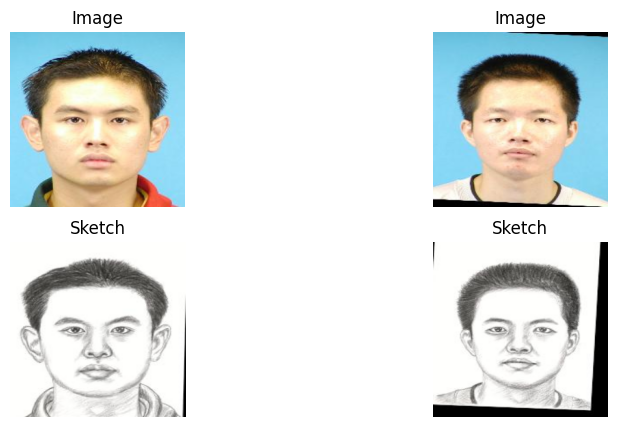

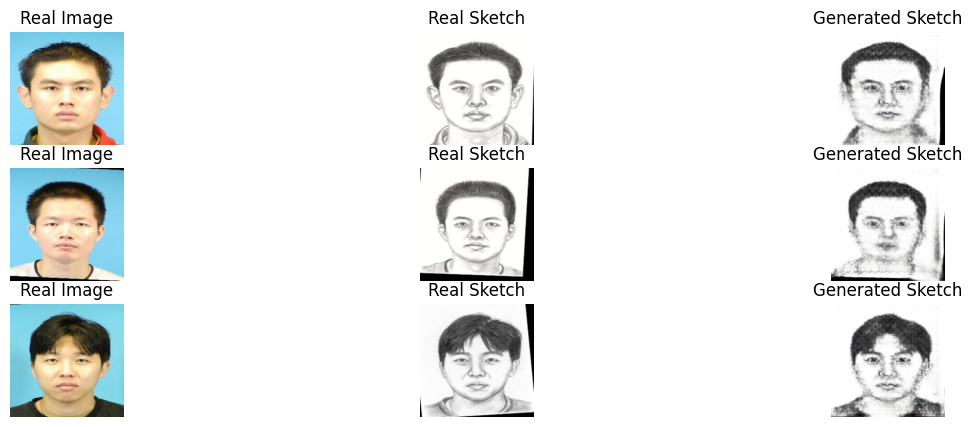

Mean Absolute Error: 0.2291


In [15]:
# Function to denormalize images
def denormalize(image):
    return (image + 1.0) * 0.5

# Function to display images and generated sketches
def show_images_from_dataset(dataset, num_images=2):
    plt.figure(figsize=(10, 5))

    # Collect a few images and sketches to display
    images_list = []
    sketches_list = []

    for images, sketches in dataset:
        images_list.extend(images.numpy())
        sketches_list.extend(sketches.numpy())

        if len(images_list) >= num_images:
            break

    # Ensure we don't exceed available images
    num_images = min(num_images, len(images_list))

    # Display the images and sketches
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(denormalize(images_list[i]))  # Denormalize to [0, 1]
        plt.title("Image")
        plt.axis("off")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(denormalize(sketches_list[i]), cmap="gray")  # Denormalize to [0, 1]
        plt.title("Sketch")
        plt.axis("off")

    plt.show()

# Load the models (assuming you have already defined encoder, generator, and discriminator)
checkpoint_dir = "/content/checkpoints"

# Create a checkpoint object
ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           encoder=encoder,
                           generator_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
                           discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
                           encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5))

# Create a checkpoint manager
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=3)

# Restore the latest checkpoint
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f'Latest checkpoint restored: {ckpt_manager.latest_checkpoint}')
else:
    print("No checkpoint found. Please ensure training has been completed and checkpoints saved.")
    exit()

# Display some test images
print("Test Dataset Samples:")
show_images_from_dataset(test_dataset)

# Perform inference
for real_images, real_sketches in test_dataset:
    latent_code = encoder(real_images, training=False)
    generated_sketches = generator(latent_code, training=False)

    # Display some generated sketches
    plt.figure(figsize=(15, 5))
    for i in range(min(len(real_images), 3)):
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(denormalize(real_images[i]))
        plt.title("Real Image")
        plt.axis("off")

        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(denormalize(real_sketches[i]), cmap="gray")
        plt.title("Real Sketch")
        plt.axis("off")

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(denormalize(generated_sketches[i]), cmap="gray")
        plt.title("Generated Sketch")
        plt.axis("off")
    plt.show()

    break  # Break after the first batch for demonstration

# Optional: Calculate and print the Mean Absolute Error
mae = tf.keras.losses.MeanAbsoluteError()
reconstruction_loss = mae(real_sketches, generated_sketches)
print(f"Mean Absolute Error: {reconstruction_loss.numpy():.4f}")

In [ ]:
! rm -rf /content/checkpoints

Latest checkpoint restored: /content/checkpoints/ckpt-1
Test Dataset Samples:


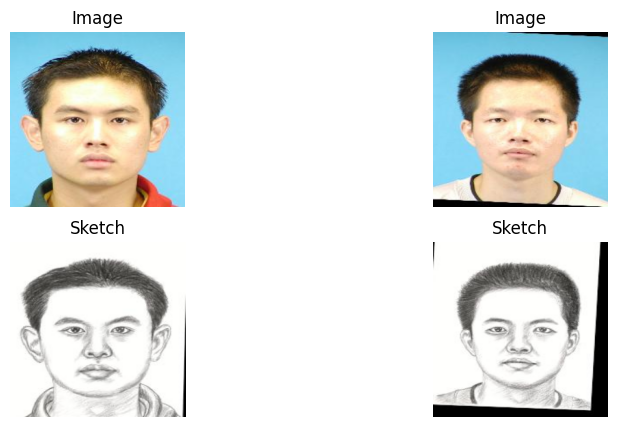

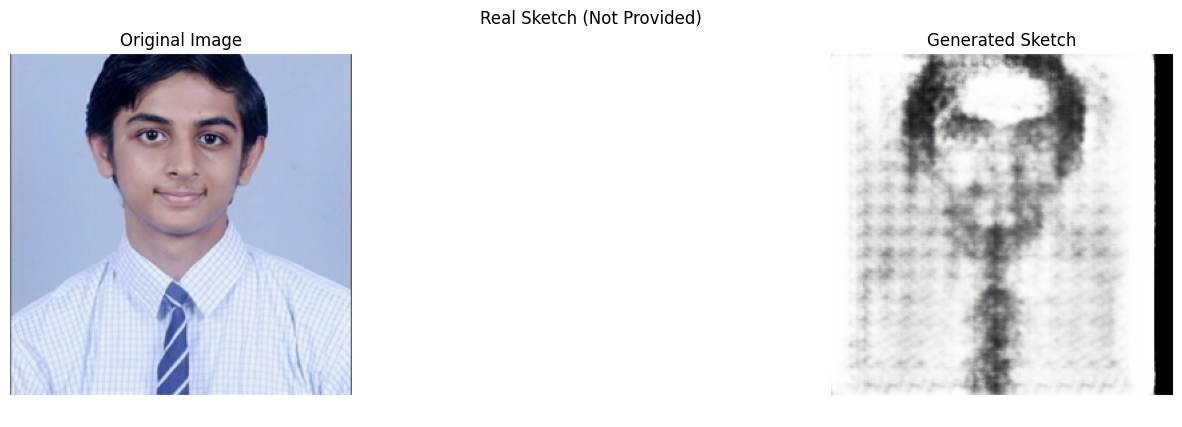

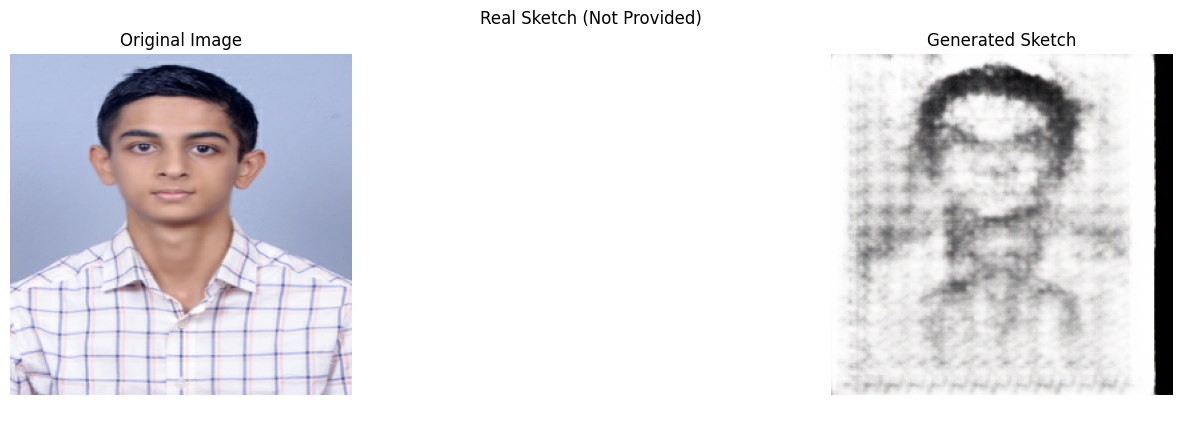

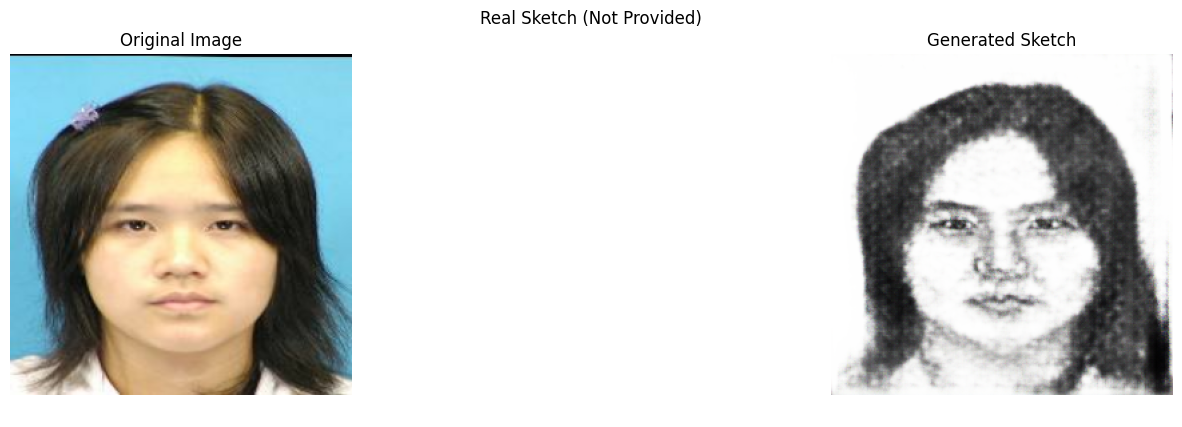

In [20]:
# Function to denormalize images
def denormalize(image):
    return (image + 1.0) * 0.5

def normalize(arr):
    arr_min = tf.reduce_min(arr)
    arr_max = tf.reduce_max(arr)
    arr_range = arr_max - arr_min
    scaled = (arr - arr_min) / arr_range
    return -1 + (scaled * 2)

# Function to preprocess a single image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, (256, 256))  # Resize to the expected input size
    image = normalize(image) # Normalize to [-1, 1]
    image = tf.expand_dims(image, 0)  # Add batch dimension
    return image

# Function to display a single image and its generated sketch
def show_image_and_sketch(image_path):
    image = preprocess_image(image_path)
    latent_code = encoder(image, training=False)
    generated_sketch = generator(latent_code, training=False)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(denormalize(image[0]))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    # Placeholder for real sketch
    plt.title("Real Sketch (Not Provided)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(denormalize(generated_sketch[0]))
    plt.title("Generated Sketch")
    plt.axis("off")

    plt.show()

# Function to display images and generated sketches from the dataset
def show_images_from_dataset(dataset, num_images=2):
    plt.figure(figsize=(10, 5))

    # Collect a few images and sketches to display
    images_list = []
    sketches_list = []

    for images, sketches in dataset:
        images_list.extend(images.numpy())
        sketches_list.extend(sketches.numpy())

        if len(images_list) >= num_images:
            break

    # Ensure we don't exceed available images
    num_images = min(num_images, len(images_list))

    # Display the images and sketches
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(denormalize(images_list[i]))  # Denormalize to [0, 1]
        plt.title("Image")
        plt.axis("off")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(denormalize(sketches_list[i]))  # Denormalize to [0, 1]
        plt.title("Sketch")
        plt.axis("off")

    plt.show()

# Load the models (assuming you have already defined encoder, generator, and discriminator)
checkpoint_dir = "/content/checkpoints"

# Create a checkpoint object
ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           encoder=encoder,
                           generator_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
                           discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
                           encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5))

# Create a checkpoint manager
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=3)

# Restore the latest checkpoint
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f'Latest checkpoint restored: {ckpt_manager.latest_checkpoint}')
else:
    print("No checkpoint found. Please ensure training has been completed and checkpoints saved.")
    exit()

# Display some test images
print("Test Dataset Samples:")
show_images_from_dataset(test_dataset)

# Perform inference on a single image
image_path = "/content/B R Arjun Old Photo.jpg"  # Replace with the path to your image
show_image_and_sketch(image_path)

image1_path = "/content/Recent Photo.jpg.JPG"  # Replace with the path to your image
show_image_and_sketch(image1_path)

image2_path = "/content/f-018-01.jpg"  # Replace with the path to your image
show_image_and_sketch(image2_path)

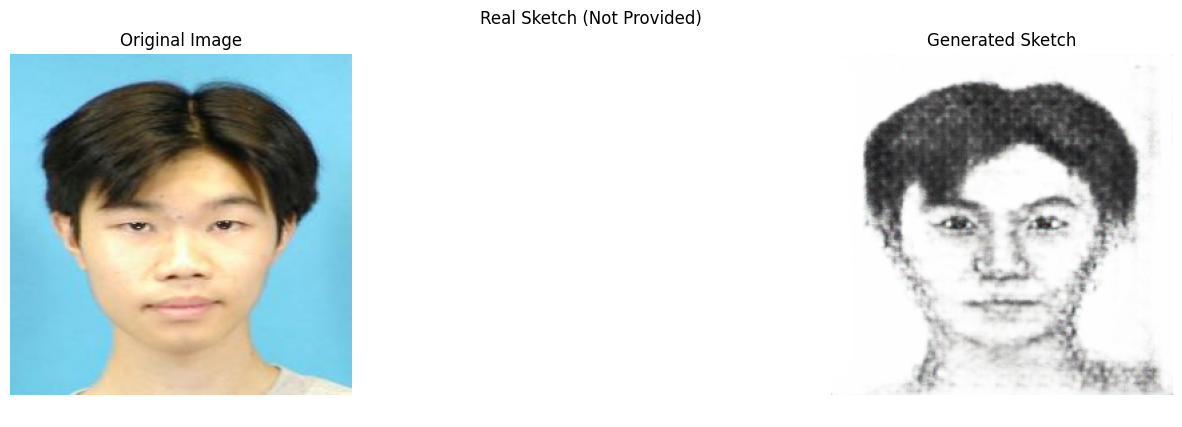

In [18]:
image3_path = "/content/m-032-01.jpg"  # Replace with the path to your image
show_image_and_sketch(image3_path)

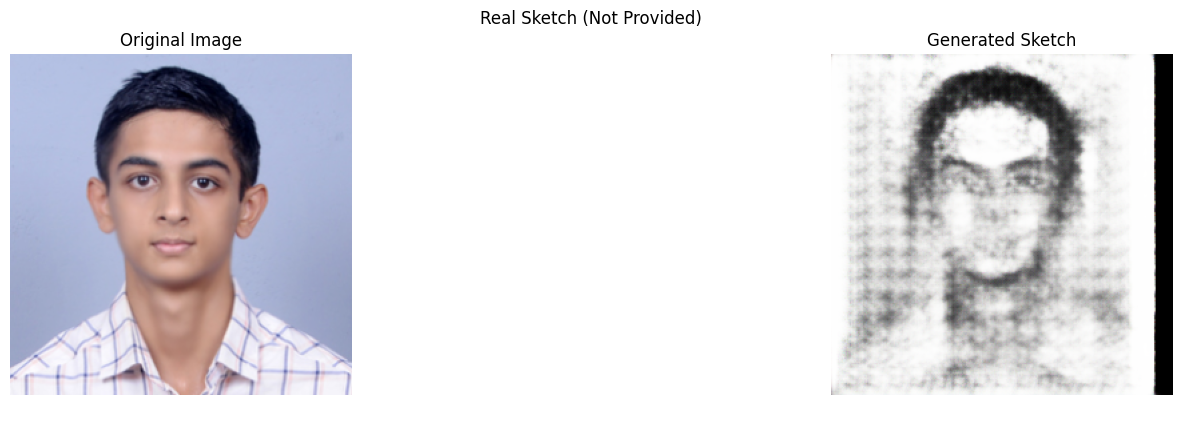

In [19]:
image4_path = "/content/Screenshot 2024-08-05 at 20-53-07 Home - Google Drive.png"  # Replace with the path to your image
show_image_and_sketch(image4_path)